In [52]:
import backtrader as bt
import pandas as pd
import pdb
import datetime
import math
from loguru import logger
from typing import List, Type

# PARAMS = dict(period5=5, period30=30)# TODO: 回测参数
class Scatter:
    def __init__(self, date, price, color, label) -> None:
        self.date = date
        self.price = price
        self.color = color
        self.label = label

SCATTERES = []
START = None
END = None

class BollBand(bt.Strategy):

    params = (
        ("short_period", 10),
        ("long_period", 30),
        ("dev_factor", 2),
        ("buy_percentage", 0.0),
        ("lookback_period", 10),  # n天的回看期
        ("buy_threshold", 0.8),   # 80%以上的收盘价大于均线时买入
    )

    def __init__(self) -> None:
        '''
        利用indicator绘制一些指标曲线
        '''
        # 短均线和长均线交叉
        self.band  = bt.indicators.BollingerBands()
        self.ma20  = bt.indicators.MovingAverageSimple(
            self.data.close, period=20
        )
        super(BollBand, self).__init__()

    def log(self):
        pass

    def notify_order(self, order: bt.Order):
        '''
        订单状态变化的事件触发函数
        '''
        # Submitted -> Accepted -> Completed 这里应该是模拟了券商
        # logger.debug(f"notify_order {bt.OrderBase.Status[order.status]}")
        pass

    def notify_trade(self, trade: bt.Trade):
        '''
        交易状态变化的事件触发函数
        '''
        # pnl (Profit and Loss)
        # pnlcomm (Profit and Loss including Commissions)
        if trade.isclosed:
            logger.info(
                "Trade Profit : {:.2f}".format(trade.pnl)# 相比于买入的时候是亏损还是赚钱
            )

    def next(self):
        '''
        实际的交易函数, 要等所有均线出现后才开始调用next, 否则是prenext
        '''
        global SCATTERES

        last_date = self.datas[0].datetime.datetime() == END

        if last_date:
            # 如果是最后一天，全部卖出
            logger.info("sell out")
            SCATTERES.append(Scatter(
                self.datas[0].datetime.datetime(),
                self.datas[0].close,
                color="Green",
                label="Sell"
            ))
            self.sell(size=self.position.size)
            return
        
        # logger.debug(self.datas[0].datetime.datetime())
        if self.datas[0].datetime.datetime() == START:
            # 如果是第一天，全部买入
            logger.info("first day buy all")
            SCATTERES.append(Scatter(
                self.datas[0].datetime.datetime(),
                self.datas[0].close,
                color="Red",
                label="Buy"
            ))
            count = self.broker.get_cash() // self.datas[0].close // 2
            count = count // 100 * 100
            submitted_orderes = self.buy(size=count, price=self.datas[0].close)
            return

        if self.data.low < self.band.lines.bot and True: # TODO: 判断资金是否足够
            count = self.broker.get_cash() // self.band.lines.bot
            count = count // 100 * 100
            logger.info(f"buy count {count}")
            # 以boll线的价格买入
            SCATTERES.append(Scatter(
                self.datas[0].datetime.datetime(),
                self.band.lines.bot,
                color="Red",
                label="Buy"
            ))
            self.buy(size=count, price=self.band.lines.bot)
            return
            
        if self.data.close[-1] < self.ma20 and self.data.close > self.ma20 and self.position:
            # 当从下方突破均线的时候就卖出30%
            # logger.info("sell 30 per")
            pass
            # SCATTERES.append(Scatter(
                # self.datas[0].datetime.datetime(),
                # self.datas[0].close,
                # color="Green",
                # label="Sell"
            # ))
            # self.sell(size=math.floor(self.position.size * self.params.buy_percentage))

        if self.data.high > self.band.lines.top and self.position:
            logger.info("sell all")
            SCATTERES.append(Scatter(
                self.datas[0].datetime.datetime(),
                self.band.lines.top,
                color="Green",
                label="Sell"
            ))
            # 以上方boll线价格卖出
            self.sell(size=self.position.size, price=self.band.lines.top)
            # self.close()
            return

        # 获取前n天的收盘价和各自均线
        close_prices_n_days = self.datas[0].close.get(size=self.params.lookback_period)
        sma_n_days = self.ma20.get(size=self.params.lookback_period)

        # 判断每天的收盘价是否都大于各自均线的比例阈值
        condition_met = [close > sma for close, sma in zip(close_prices_n_days, sma_n_days)]

        if len([cond for cond in condition_met if cond is True]) / len(condition_met) > self.params.buy_threshold:
            if self.datas[0].low < self.ma20:
                count = self.broker.get_cash() // self.ma20 * 0.7
                count = count // 100 * 100
                logger.info(f"buy count {count} by ma")
                # 以boll线的价格买入
                SCATTERES.append(Scatter(
                    self.datas[0].datetime.datetime(),
                    self.band.lines.bot,
                    color="Red",
                    label="Buy"
                ))
                self.buy(size=count, price=self.ma20)
                return


import tushare as ts

# df = ts.get_hist_data("601058").sort_values(by="date",ascending=True)
df = ts.get_hist_data("002743").sort_values(by="date",ascending=True)
# print(df)
# df = pd.read_csv("assets/yiling.csv")
# not use the "Adj Close" colomn
# selected_colomns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
# df.loc[:, 'date'] = pd.to_datetime(df['date'])
df.index = pd.to_datetime(df.index)
df["date"] = df.index.copy()
# df = df[df.index < datetime.datetime(year=2022,month=7,day=1)]
START = df.index.min()
END = df.index.max()
# print(df)

# df = df[selected_colomns]

cerebro = bt.Cerebro()
data = bt.feeds.PandasData(
    dataname=df,
    datetime='date',  # 必须指定日期列的名称
    open='open',
    high='high',
    low='low',
    close='close',
    volume='volume',
    timeframe=bt.TimeFrame.Days,
    # fromdate=datetime.datetime(2021, 8, 16), 
    # todate=datetime.datetime(2022, 8, 15)
)# 以日频加载数据

cerebro.adddata(data, name="SLLT")
cerebro.addstrategy(BollBand)
# Sizer: 它根据资产总价值的百分比来确定每次交易的大小 这里是每次交易90%
cerebro.addsizer(bt.sizers.PercentSizer, percents=90)

cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="mysharp")
cerebro.addanalyzer(bt.analyzers.Returns, _name="myreturn")

# print(cerebro.broker.getvalue()) # NOTE: 默认10000.0$ 
cerebro.broker.set_cash(10000 * 50)
origin_cash = cerebro.broker.getvalue()

result: List[bt.Strategy] = cerebro.run()
# logger.debug(result[0].analyzers.myreturn)

mysharp : bt.analyzers.SharpeRatio = result[0].analyzers.mysharp
myreturn: bt.analyzers.Returns     = result[0].analyzers.myreturn

def months_between_dates(date1, date2):
    delta = date1 - date2
    months = (delta.days / 30.44)
    return abs(int(months))

years = months_between_dates(END, START) / 12

# 夏普率的本质就是 收益率/波动率 波动率就是用标准差计算
logger.info("夏普率: {:.2f}".format(mysharp.get_analysis()['sharperatio']))
logger.info("总回报率: {:.2%}".format(myreturn.get_analysis()['rtot']))
logger.info("年化回报率: {:.2%}".format(myreturn.get_analysis()['rtot'] / years))
logger.info("账户原始余额: {}".format(origin_cash))
logger.info("账户回测余额: {:.1f}".format(cerebro.broker.getvalue()))



本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


2024-02-01 14:36:21.092 | INFO     | __main__:next:150 - buy count 45100.0 by ma
2024-02-01 14:36:21.094 | INFO     | __main__:next:150 - buy count 11500.0 by ma
2024-02-01 14:36:21.100 | INFO     | __main__:next:127 - sell all
2024-02-01 14:36:21.101 | INFO     | __main__:notify_trade:61 - Trade Profit : -64443.00
2024-02-01 14:36:21.102 | INFO     | __main__:next:150 - buy count 46300.0 by ma
2024-02-01 14:36:21.103 | INFO     | __main__:next:103 - buy count 21400.0
2024-02-01 14:36:21.105 | INFO     | __main__:next:127 - sell all
2024-02-01 14:36:21.106 | INFO     | __main__:notify_trade:61 - Trade Profit : 15742.00
2024-02-01 14:36:21.107 | INFO     | __main__:next:150 - buy count 47100.0 by ma
2024-02-01 14:36:21.110 | INFO     | __main__:next:150 - buy count 13900.0 by ma
2024-02-01 14:36:21.114 | INFO     | __main__:next:127 - sell all
2024-02-01 14:36:21.115 | INFO     | __main__:notify_trade:61 - Trade Profit : 31411.00
2024-02-01 14:36:21.117 | INFO     | __main__:next:150 - 

/home/squ/.local/lib/python3.8/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


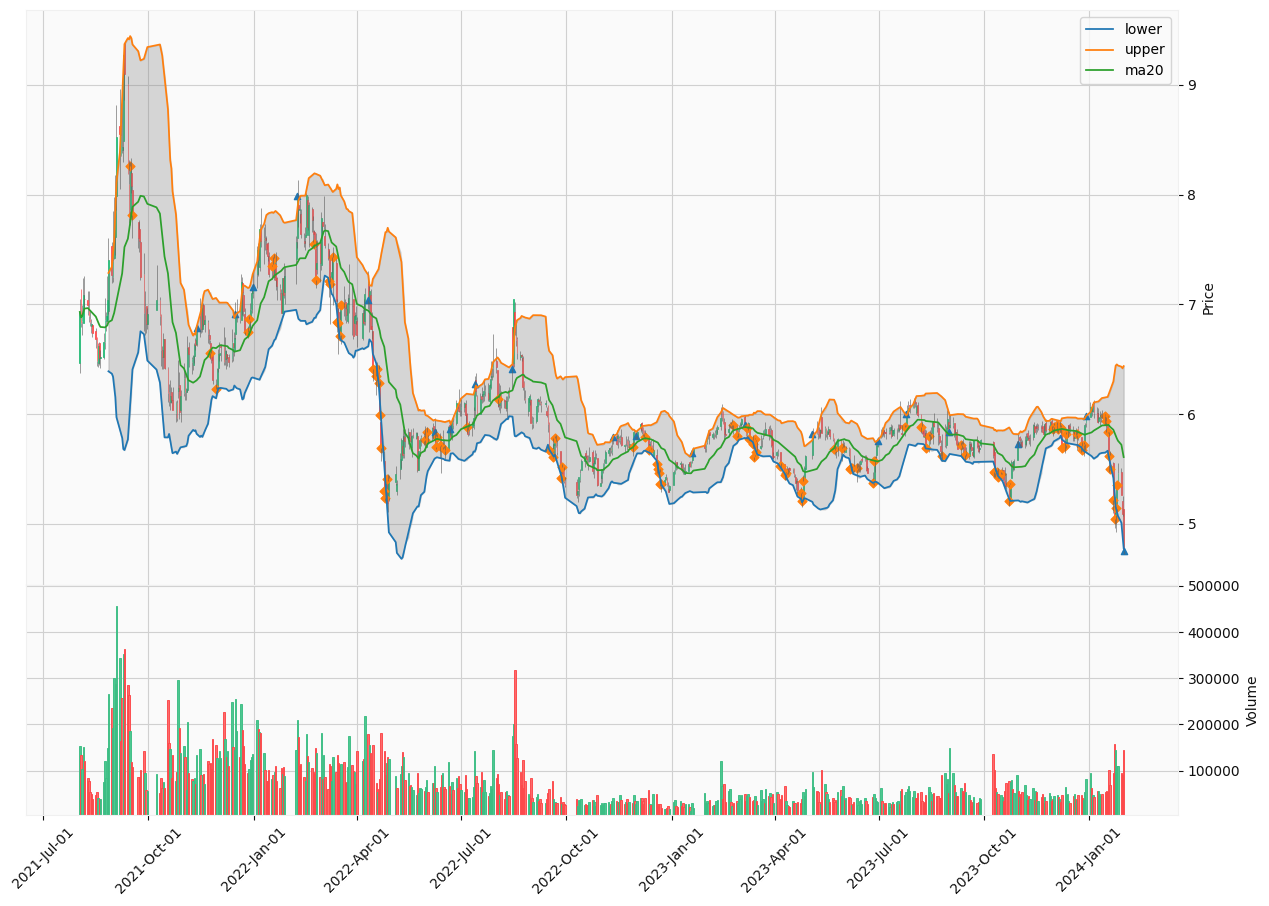

In [53]:
import matplotlib.pyplot as plt
# 设置DISPLAY变量进行X11本地绘图转发
# cerebro.plot(style='candle', barup='green', bardown='red', iplot=False, volume=False, fmt_x_data='%Y-%m-%d %H:%M:%S')
# plt.savefig('backtrader_plot.png')


import mplfinance as mpf

# 计算均线和布林带
df['upper'] = df['ma20'] + 2 * df['close'].rolling(window=20).std()
df['lower'] = df['ma20'] - 2 * df['close'].rolling(window=20).std()

sell_x = []
sell_y = []

buy_x = []
buy_y = []
for sca in SCATTERES:
    if sca.label == "Sell":
        sell_x.append(sca.date)
        sell_y.append(df.loc[sca.date, 'close'])
    else:
        buy_x.append(sca.date)
        buy_y.append(df.loc[sca.date, 'close'])

apdict = [mpf.make_addplot(df['lower'],label="lower"),
          mpf.make_addplot(df['upper'],label="upper"),
          mpf.make_addplot(df['ma20'],label="ma20")]

# 创建一个subplot，用于绘制蜡烛图
fig, axlist = mpf.plot(
    df, 
    type='candle',
    style="yahoo",
    volume=True,
    figscale=2,
    addplot=apdict,              # 增加格外的plot 比如我这里加了bollinger线
    show_nontrading=True,
    returnfig=True,
    fill_between=dict(y1=df['lower'].values,y2=df['upper'].values,alpha=0.3,color='grey'), # 填充布林线 alpha应该是透明度
    # savefig=dict(fname='output.svg', format='svg') # 保存为矢量图
    # savefig=dict(fname='output.png', format='png') 
)
ax = axlist[0]
ax.scatter(sell_x, sell_y, s=20, marker='^')#, coler="green")
ax.scatter(buy_x, buy_y, s=20, marker='D')#, coler="red")
# 显示图表
mpf.show()